In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Загружаем данные
data = pd.read_csv('Churn_Modelling.csv')

# анализ релевантности признаков

https://www.machinelearningmastery.ru/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04/

При анализе релевантности признаков ставится задача выбрать признаки, оказывающие наибольшее влияние на целевую переменную. В нашем случае на отток.
Признаки, которые показывают наибольшую степень сегрегации по отношению к оттоку (отток = «Да» или «Нет») по анализу релевантности, мы будем использовать для построения прогнозирующей модели оттока.
Анализ релевантности признаков можно использовать для любой задачи бинарной классификации, когда нас интересует ответ «Да» или «Нет». Он основан на двух показателях:
Информационная ценность - information value (IV)
и
Вес доказательств - weight of evidence (WoE).

Вес доказательств говорит о предсказательной способности независимой переменной по отношению к зависимой переменной. Так как он произошел из мира кредитного скоринга, его обычно описывают как меру разделения хороших и плохих клиентов. «Плохие клиенты» - не выполнили свои обязательства по кредиту. «Хорошие клиенты» - вернули кредит. 

Информационная ценность - один из наиболее полезных методов выбора важных признаков в прогнозной модели. Он помогает ранжировать переменные на основе их важности.

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Основные требования к данным
+ Набор данных должен быть чистым. Вы можете заполнить пропущенные значения буквально словом ‘ОТСУТСТВУЕТ». Лучше сделать именно так, чтобы увидеть, как пропущенные значения связаны с целевой переменной.
+ Там не должно быть никаких непрерывных признаков. Признаки, которые представляют возраст, стоитмость, объем или что-либо непрерывное, должны быть сгруппированы в 5–10 бинов. Просто убедитесь, что каждый бин имеет не менее 5% наблюдений.

## Почистим данные и сформируем бины

In [5]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data_bins = data.copy()

data_bins['CreditScore_Bins'] = pd.qcut(data['CreditScore'], 5, 
                                   labels=['CS_lt_566', 'CS_556_to_627', 'CS_627_to_678', 'CS_678_to_735', 'CS_gt_735'])
data_bins['Age_Bins'] = pd.qcut(data['Age'], 5, 
                           labels=['Age_lt_31', 'Age_31_to_35', 'Age_35_to_40', 'Age_40_to_46', 'Age_gt_46'])
data_bins['Balance_Bins'] = pd.qcut(data['Balance'], 5, 
                               labels=['Bal_lt_73080', 'Bal_73080_to_110138', 'Bal_110138_to_133710', 'Bal_gt_133710'],
                               duplicates='drop')
data_bins['Salary_Bins'] = pd.qcut(data['EstimatedSalary'], 5, 
                              labels=['Sal_lt_41050', 'Sal_41050_to_80238', 'Sal_80238_to_119710', 'Sal_119710_to_159836', 'Sal_159836_to_199992'])

data_bins.drop(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], axis=1, inplace=True)

In [6]:
data_bins

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,CreditScore_Bins,Age_Bins,Balance_Bins,Salary_Bins
0,France,Female,2,1,1,1,1,CS_556_to_627,Age_40_to_46,Bal_lt_73080,Sal_80238_to_119710
1,Spain,Female,1,1,0,1,0,CS_556_to_627,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710
2,France,Female,8,3,1,0,1,CS_lt_566,Age_40_to_46,Bal_gt_133710,Sal_80238_to_119710
3,France,Female,1,2,0,0,0,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
4,Spain,Female,2,1,1,1,0,CS_gt_735,Age_40_to_46,Bal_110138_to_133710,Sal_41050_to_80238
...,...,...,...,...,...,...,...,...,...,...,...
9995,France,Male,5,2,1,0,0,CS_gt_735,Age_35_to_40,Bal_lt_73080,Sal_80238_to_119710
9996,France,Male,10,1,1,1,0,CS_lt_566,Age_31_to_35,Bal_lt_73080,Sal_80238_to_119710
9997,France,Female,7,1,0,1,1,CS_678_to_735,Age_35_to_40,Bal_lt_73080,Sal_41050_to_80238
9998,Germany,Male,3,2,1,0,1,CS_gt_735,Age_40_to_46,Bal_73080_to_110138,Sal_80238_to_119710


## функция расчета информационной ценности и веса доказательства

In [7]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

## Расчитываем показатели по колонкам

In [8]:
for col in data_bins.columns:
    if col == 'Exited': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data, col, 'Exited')
        print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Geography
     Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
2  Germany  2509  1695  814    0.212859   0.399607 -0.629850  0.117623
1    Spain  2477  2064  413    0.259199   0.202749  0.245626  0.013865
0   France  5014  4204  810    0.527942   0.397644  0.283430  0.036930
IV score: 0.17


WoE and IV for column: Gender
    Value   All  Good   Bad  Distr_Good  Distr_Bad       WoE        IV
0  Female  4543  3404  1139    0.427477   0.559156 -0.268527  0.035359
1    Male  5457  4559   898    0.572523   0.440844  0.261361  0.034416
IV score: 0.07


WoE and IV for column: Tenure
    Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
10      0   413   318   95    0.039935   0.046637 -0.155153  0.001040
1       1  1035   803  232    0.100841   0.113893 -0.121710  0.001589
9       9   984   771  213    0.096823   0.104566 -0.076931  0.000596
6       3  1009   796  213    0.099962   0.104566 -0.045021  0.000207
8       5  1012   803  209

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: 'CreditScore_Bins'

Смотрим на строки с достаточно большим IV
Если
+ IV < 0,02 - бесполезный предиктор
+ 0,02 < IV < 0,1 - слабый предиктор
+ 0,1 < IV < 0,3 - средний предиктор
+ 0,3 < IV < 0,5 - сильный предиктор
+ 0,5 < IV - подозрительно хорошо, чтобы быть правдой

нас будут интересовать признаки, с хорошей предсказательной силой. В нашем случае это:
+ NumOfProducts(0,80)
+ Age_Bins(0,74)
+ Geography(0,17)
+ IsActiveMember(0,15)

Рассмотрим колонку WoE в наших признаках.
Большие отрицательные значения указывают, что данное значение признака тяготит клиента уйти, а большие положительные - остаться.
В нашем случае географическое положение клиента в Германии сильно тяготит его к оттоку.

Типичный портрет уходящего клиента:
+ Живет в Германии (WoE -0,63)
+ Использует 3 продукта / услуги (WoE -2,92)
+ Не активный участник (WoE -0.36)
+ Возраст 46+ (WoE -1.20)

Типичный портрет работающего клиента:
+ Живет во Франции (WoE 0,28) 
+ Использует 2 продукта / услуги (WoE 1.13)
+ Активный участник (WoE 0.42)
+ Возраст 31- (WoE 1.13)

Базовый релевантный анализ признаков позволяет быстро оценить значимость и характер влияния признаков на целевую переменную.

# Построим модель прогнозирования оттока

вначале используем все признаки, которые есть в данных

In [9]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [10]:
col=['NumOfProducts', 'Geography', 'Age', 'IsActiveMember',
    'CreditScore',  'Gender',  'Tenure', 'Balance', 'HasCrCard',  'EstimatedSalary'
    ] # !!!!! Укажите здесь названия столбцов своего датасета!

# код ниже преобразует категорийные данные в переменные и заполняет пропуски наиболее вероятным значением
X=pd.DataFrame()
for i in col:
    if data[i].dtype.name != 'object':
        X[i]=data[i].copy()
        X.loc[X[i].isna(), i]=X[i].median()
    else:
        X[i]=pd.factorize(data[i])[0]

In [11]:
# результат, подготовленные данные
X.sample(3)

,NumOfProducts,Geography,Age,IsActiveMember,CreditScore,Gender,Tenure,Balance,HasCrCard,EstimatedSalary
8265,1.0,2,40.0,0.0,618.0,0,0.0,140306.38,1.0,160618.61
9661,2.0,0,39.0,0.0,675.0,0,6.0,0.00,0.0,83419.15
1556,2.0,1,29.0,1.0,850.0,0,10.0,0.00,1.0,94815.04


In [12]:
# Y будет равен нулю если клиент остался Exited == 0, и единице если ушел Exited == 1
Y=data['Exited'].values

In [13]:
#разделим набор на тренировочный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
# создаем и тренируем модель, отдельно можно провести подбор параметров для повышения точности
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.2358, 'Age'],
 [0.1448, 'EstimatedSalary'],
 [0.1441, 'CreditScore'],
 [0.1418, 'Balance'],
 [0.129, 'NumOfProducts'],
 [0.0812, 'Tenure'],
 [0.0432, 'IsActiveMember'],
 [0.0414, 'Geography'],
 [0.0194, 'Gender'],
 [0.0192, 'HasCrCard']]

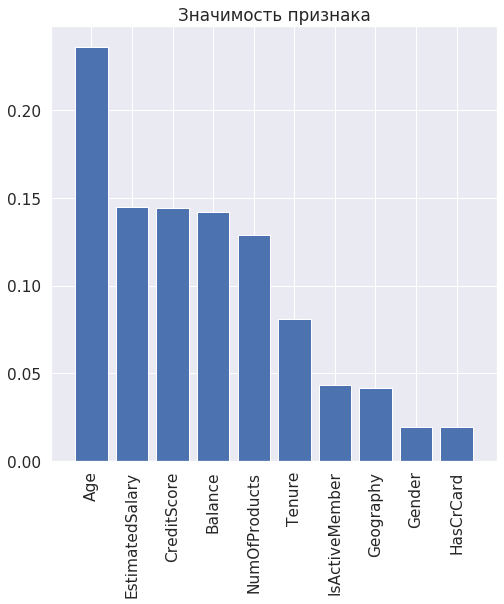

In [35]:
#удобнее отобразить на столбчатой диаграмме
d_first = len(col)
plt.figure(figsize=(8, 8))
plt.title("Значимость признака")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(col)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [36]:
# как выглядит результат предсказания для тестовой выборки
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [37]:
# как выглядядт результаты тестового набора
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
from sklearn import metrics
# метрика, насколько точно мы предсказываем правильные значения как для 0, так и 1
print("Accuracy:",metrics.accuracy_score(y_test, model.predict(X_test)))

Accuracy: 0.871


In [39]:
# матрица количества правильно и ошибочно угаданных классов
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test))

array([[1550,   57],
       [ 201,  192]])

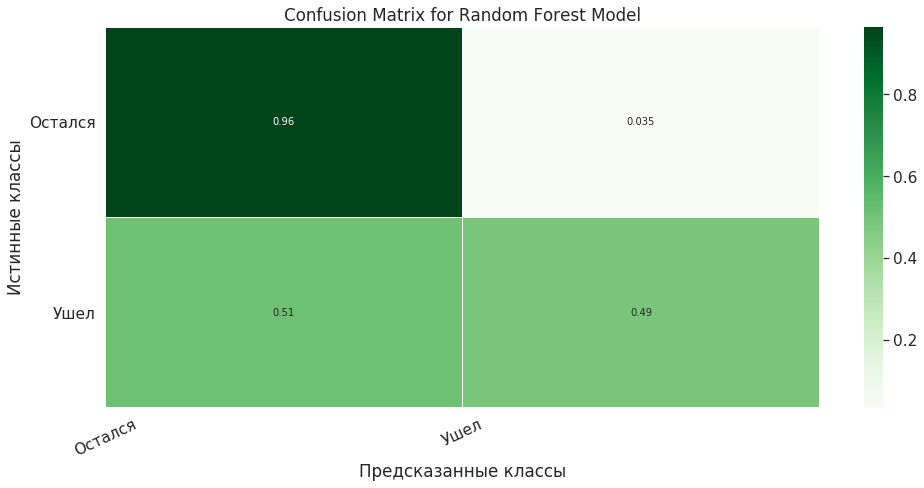

In [40]:
# так же матрица в процентах и более изящном виде
matrix = confusion_matrix(y_test, model.predict(X_test))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Остался', 'Ушел']                 # !!!!!! указать названия классов!
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [22]:
# Еще базовые метрики оценки точности модели
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.77      0.49      0.60       393

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [25]:
from xgboost import XGBClassifier as xgb

In [78]:
# создаем и тренируем модель, отдельно можно провести подбор параметров для повышения точности
model_xgb = xgb()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.3125, 'NumOfProducts'],
 [0.2157, 'IsActiveMember'],
 [0.1294, 'Age'],
 [0.0701, 'Geography'],
 [0.0584, 'Balance'],
 [0.0498, 'Gender'],
 [0.0443, 'HasCrCard'],
 [0.0415, 'CreditScore'],
 [0.0404, 'EstimatedSalary'],
 [0.0379, 'Tenure']]

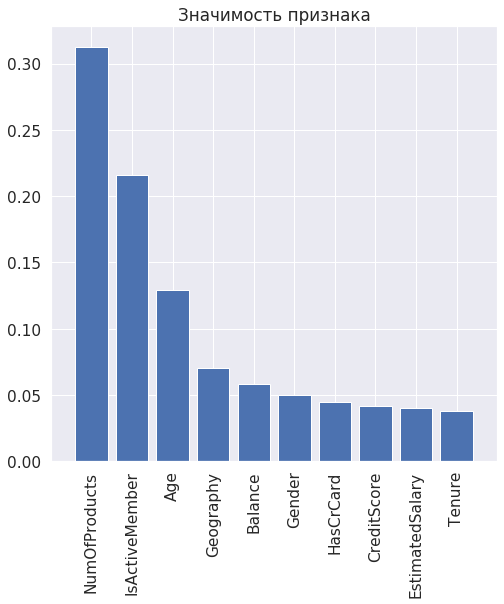

In [80]:
#удобнее отобразить на столбчатой диаграмме
d_first = len(col)
plt.figure(figsize=(8, 8))
plt.title("Значимость признака")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(col)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [81]:
# как выглядит результат предсказания для тестовой выборки
model_xgb.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [82]:
# как выглядядт результаты тестового набора
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [83]:
from sklearn import metrics
# метрика, насколько точно мы предсказываем правильные значения как для 0, так и 1
print("Accuracy:",metrics.accuracy_score(y_test, model_xgb.predict(X_test)))

Accuracy: 0.861


In [84]:
# матрица количества правильно и ошибочно угаданных классов
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model_xgb.predict(X_test))

array([[1530,   77],
       [ 201,  192]])

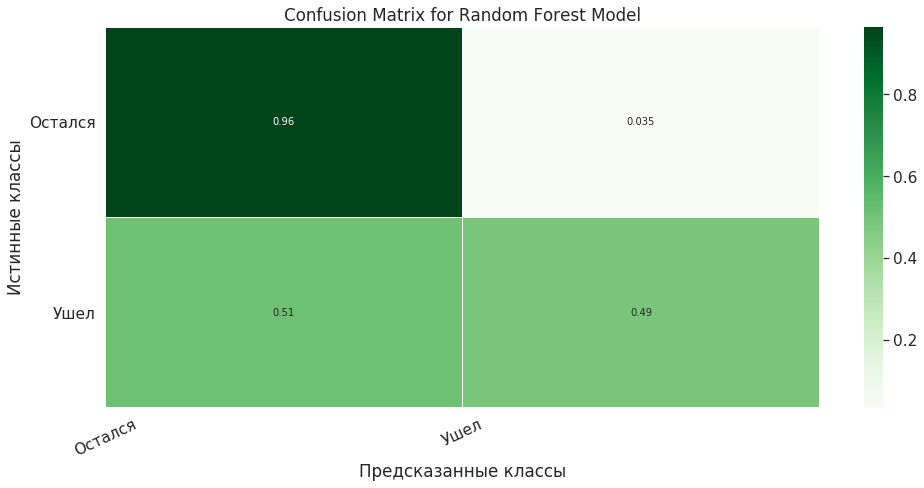

In [85]:
# так же матрица в процентах и более изящном виде
matrix = confusion_matrix(y_test, model.predict(X_test))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Остался', 'Ушел']                 # !!!!!! указать названия классов!
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()